# WeMoms recommendation algorithm

This notebook aims at proposing an algorithm to identify which posts should be suggested to the moms which just installed the app. The goal is to incite them to post, or comment an existing post, on the first day they use the app.

This has been performed using classical data exploration methods, centered on provided informations about moms, comments and posts. Due to time constraints and the lack of link between comments and initial post, the text itself of the posts/comments has not been considered in this study.


The documents is organized as follow:
- Imports data
- Enrich data: perform feature engineering to ease the access to the information.
- Explore data: discover, understand what's inside the data. Identify useful insights regading our topic.
- Recommandation algorithm: Use insights to propose an algorithm.



Note: Appendices contains a fail attempt to modelize moms behaviour using machine learning. It provides rich insights and is worth reading.

In [1]:
# import data vizualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
# import data manipulation and machine learning libraries
import pandas as pd
import numpy as np
import sklearn

In [3]:
from datetime import date

# Import Data

Imports the 3 provided datasets: users, comments, posts.<br>
For the sake of clarity, first data exploration steps (unidimensional exploration, missing data, duplicates, ...) has been removed from the document.

In [20]:
users = pd.read_csv("data/users.csv", index_col="uuid", parse_dates=["last_opening", "created_at", "birthday"])
print("Number of users: ", users.shape[0])

comments = pd.read_csv("data/comments.csv", index_col="uuid", parse_dates=["created_at"])
print("Number of comments: ", comments.shape[0])

posts = pd.read_csv("data/posts.csv", index_col="uuid", parse_dates=["created_at"])
print("Number of Posts: ", posts.shape[0])

Number of users:  85748
Number of comments:  79928
Number of Posts:  22407


# Feature engineering

Some informations carried by the datasets have to be reworked so they can be used to perform analysis or run machine learning models.

## Basic feature engineering

In [21]:
comments["has_club"] = ~comments["club_id"].isnull()
comments["has_picture"] = ~comments["picture_id"].isnull()

posts["has_club"] = ~posts["club_id"].isnull()
posts["has_picture"] = ~posts["picture_id"].isnull()

In [22]:
users["creation_date"] = users["created_at"].dt.date
comments["creation_date"] = comments["created_at"].dt.date
posts["creation_date"] = posts["created_at"].dt.date

In [23]:
users.loc[:,"filled_birthdate"] = ~users["birthday"].isnull()

In [24]:
# Compute age
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

users["age"] = users["birthday"].apply(func=calculate_age)
users.drop("birthday", axis=1, inplace=True)

In [25]:
# Impute with 53 age outliers (negative ages, mom being 120 years old, ...)
age_impute = users["age"].mean()
users.loc[(users["age"] < 13) | (users["age"] > 70), "age"] =  age_impute

## Extract moms from users

In [30]:
moms = users[users.is_mom == 1].copy()
print("Number of moms:", moms.shape[0])
print("Number of users: ", users.shape[0])

Number of moms: 21968
Number of users:  85748


On the provided dataset, among 85748 users, only a quarter of them (21968) are moms.

## Identify moms who posted on day 1

To be able to analyze the moms who posted on day 1 behaviour, we have to identify them.<br> We also have to identify the posts/comments which they have created on their first day.

In [27]:
moms_created_date = moms.loc[:, "creation_date"]
comments_created_date = comments.loc[:, ["user_id", "creation_date"]]
posts_created_date = posts.loc[:, ["user_id", "creation_date"]]

In [31]:
# identify moms who commented the first day
comments_moms = comments_created_date.join(moms_created_date, 
                                                    on="user_id", 
                                                    lsuffix="_comment", 
                                                    rsuffix="_user", 
                                                    how="inner")

posts_moms = posts_created_date.join(moms_created_date, 
                                              on="user_id",
                                              lsuffix="_posts", 
                                              rsuffix="_user",
                                              how="inner")

print("Number of comments which have been created by moms:", comments_moms.shape[0])
print("Number of posts which have been created by moms:", posts_moms.shape[0])

Number of comments which have been created by moms: 7191
Number of posts which have been created by moms: 2077


In [33]:
comments_first_day = comments_moms.loc[(comments_moms.creation_date_comment == comments_moms.creation_date_user)]
posts_first_day = posts_moms.loc[(posts_moms.creation_date_posts == posts_moms.creation_date_user)]
print("Number of comments which have been created by moms at day 1:", comments_first_day.shape[0])
print("Number of posts which have been created by moms at day 1:", posts_first_day.shape[0])

Number of comments which have been created by moms at day 1: 3074
Number of posts which have been created by moms at day 1: 825


In [35]:
moms_comments_first_day = comments_first_day.user_id.unique()
moms_posts_first_day = posts_first_day.user_id.unique()
print("Number of moms who commented at day 1:", moms_comments_first_day.shape[0])
print("Number of moms who posted at day 1:", moms_posts_first_day.shape[0])

Number of moms who commented at day 1: 1172
Number of moms who posted at day 1: 268


In [84]:
moms["comments_on_first_day"] = moms.index.isin(moms_comments_first_day)
moms["posts_on_first_day"] = moms.index.isin(moms_posts_first_day)
moms["posts_or_comments_on_first_day"] = moms["comments_on_first_day"] | moms["posts_on_first_day"]

On the 21968 users flagged as moms:
- 1172 moms commented on their first day for an average of 2.6 comments by mom. <br>
- 268 moms posted on their first day for an average of 3 posts by mom.

In [37]:
comments["posted_day_1"] = comments["user_id"].isin(moms_comments_first_day)
posts["posted_day_1"] = posts["user_id"].isin(moms_comments_first_day)

# Data exploration

## Current rate of moms who post or comment on day 1

In the provided dataset, only 5% of moms post or comment on day 1.

In [85]:
post_or_comment_day_1_rate = moms["posts_or_comments_on_first_day"].sum() / moms.shape[0]
print("Rate of moms who post or comment on day 1:", "{:.3f}".format(post_or_comment_day_1_rate))

Rate of moms who post or comment on day 1: 0.053


## Understand what makes a post/comment generates actions

### Likes overview

Insights: 
- Comments and posts which are part of a club generate twice as much likes.
- Comments and posts which contains a picture also generate twice as much likes.

<AxesSubplot:title={'center':'Posts with picture likes count'}, xlabel='has_picture', ylabel='likes_count'>

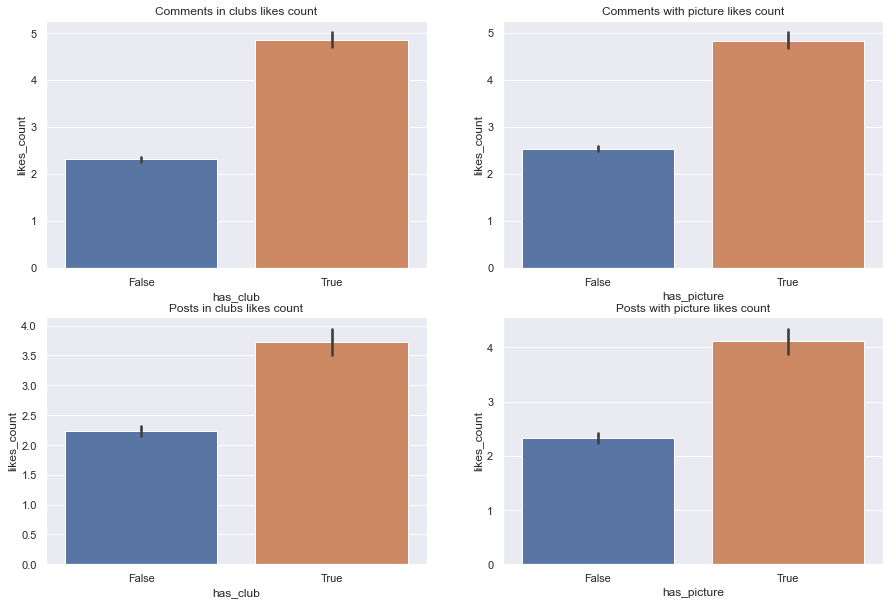

In [38]:
sns.set(rc = {'figure.figsize':(15, 10)})
fig, ax = plt.subplots(2,2)
ax[0,0].set_title("Comments in clubs likes count")
ax[0,1].set_title("Comments with picture likes count")
ax[1,0].set_title("Posts in clubs likes count")
ax[1,1].set_title("Posts with picture likes count")

sns.barplot(x="has_club", y="likes_count", data=comments, ax=ax[0,0])
sns.barplot(x="has_picture", y="likes_count", data=comments, ax=ax[0,1])
sns.barplot(x="has_club", y="likes_count", data=posts, ax=ax[1,0])
sns.barplot(x="has_picture", y="likes_count", data=posts, ax=ax[1,1])

### Comments overview

Insights:
- Comments which are part of a club generate more comments (1 more in average).<br>
- For posts, the difference isn't as significant but still, being part of club generates more comments.<br>
- Posts and comments having a picture are far less commented (5 less !), liking them seems to be the way to show approval.

<AxesSubplot:title={'center':'Posts with picture comments count'}, xlabel='has_picture', ylabel='comments_count'>

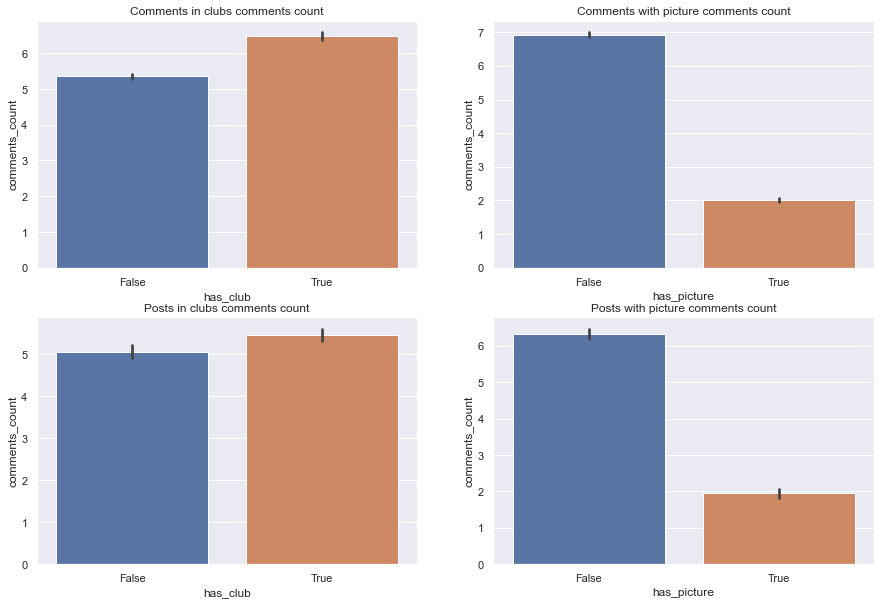

In [39]:
sns.set(rc = {'figure.figsize':(15, 10)})
fig, ax = plt.subplots(2,2)
ax[0,0].set_title("Comments in clubs comments count")
ax[0,1].set_title("Comments with picture comments count")
ax[1,0].set_title("Posts in clubs comments count")
ax[1,1].set_title("Posts with picture comments count")

sns.barplot(x="has_club", y="comments_count", data=comments, ax=ax[0,0])
sns.barplot(x="has_picture", y="comments_count", data=comments, ax=ax[0,1])
sns.barplot(x="has_club", y="comments_count", data=posts, ax=ax[1,0])
sns.barplot(x="has_picture", y="comments_count", data=posts, ax=ax[1,1])

## Focus on comments posted day 1
Here we want to understand some elements of structure of the comments posted by the moms at day 1 so we can recommend the right posts to the future newcomers.

### Which club_id are used to post or comment on day 1 ?

Insigths:
- A very large part of the first comments and posts happen in 3 clubs
- The club with the most actions at day 1 is not the same for comments and posts
- For comments  0da072ea-7843-11ec-8ab9-528475e5e84a is very dominant
- For posts a9f8791a-8ab5-11ec-ab57-0af595570d4e is the most used

In [47]:
# Count the number of comment day 1 by club_id
club_id_count_day_1_comments = comments.loc[comments["posted_day_1"], ['user_id', 'club_id']] \
                                  .groupby('club_id') \
                                  .count() \
                                  .sort_values(by='user_id', ascending=False)

club_id_count_day_1_comments.rename(columns={'user_id': 'count'}, inplace=True)

# Count the number of posts day 1 by club_id
club_id_count_day_1_posts = posts.loc[posts["posted_day_1"], ['user_id', 'club_id']] \
                                  .groupby('club_id') \
                                  .count() \
                                  .sort_values(by='user_id', ascending=False)

club_id_count_day_1_posts.rename(columns={'user_id': 'count'}, inplace=True)

In [50]:
# Merge comments & posts
club_id_count_day_1_comments_and_posts = club_id_count_day_1_comments.join(club_id_count_day_1_posts, lsuffix='_comments', rsuffix='_posts')

# prepare format to make graphs
club_id_count_day_1_comments_and_posts = club_id_count_day_1_comments_and_posts.stack().reset_index()
club_id_count_day_1_comments_and_posts.columns = ["club_id", "message_type", "count"]

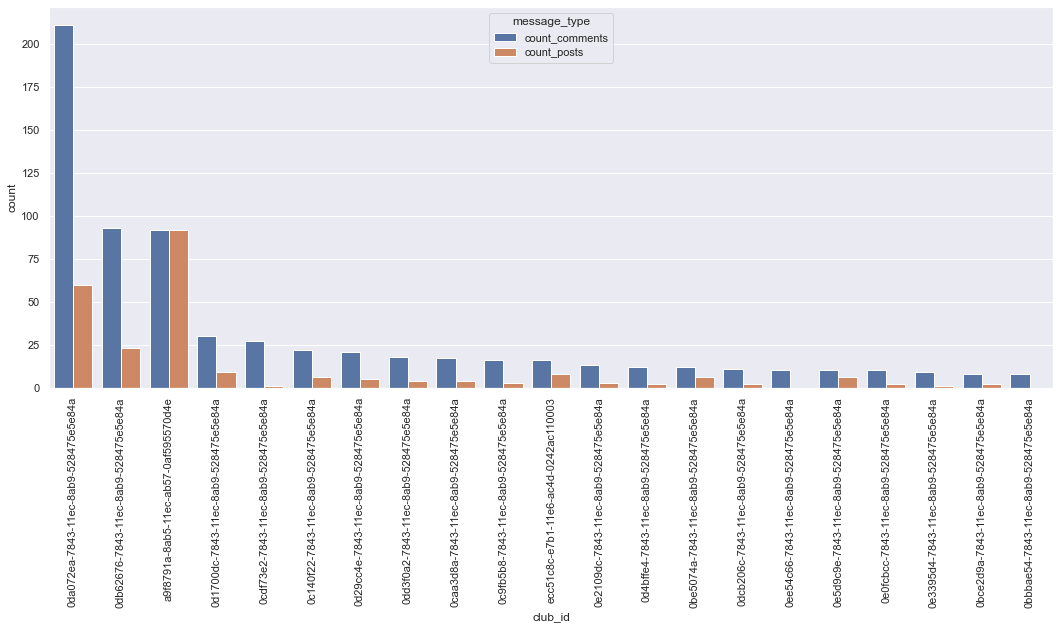

In [51]:
sns.set(rc = {'figure.figsize':(18,7)})
plt.xticks(rotation=90)
ax = sns.barplot(x="club_id", hue="message_type", y='count', data=club_id_count_day_1_comments_and_posts.iloc[:40])

### Do the comments on day 1 get pictures ? are they posted in a club ?

Insights:
- Most of day 1 comments & posts contains pictures
- Most of day 1 comments & posts are not part of a club

<AxesSubplot:title={'center':'Posts day 1 with picture comments count'}, xlabel='has_picture', ylabel='count'>

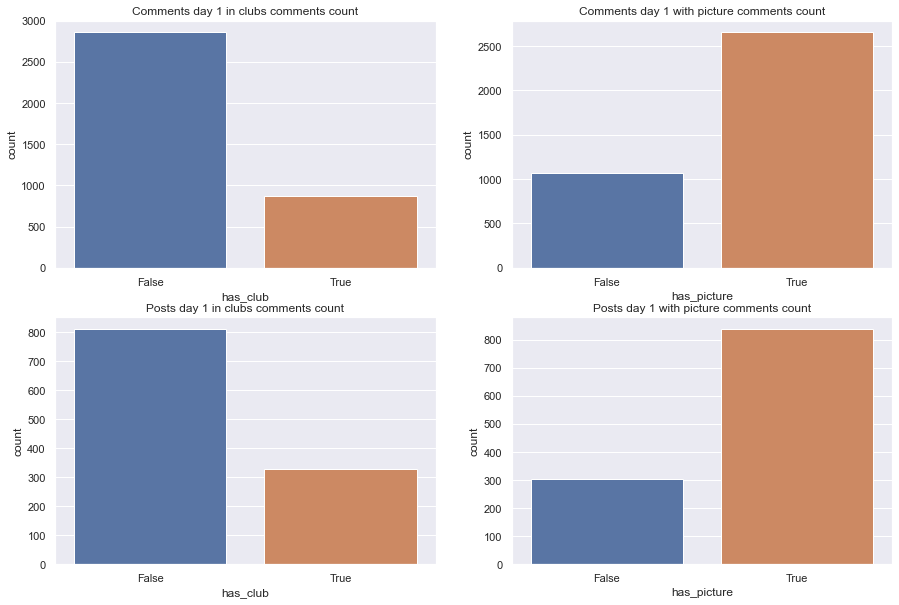

In [87]:
sns.set(rc = {'figure.figsize':(15, 10)})
fig, ax = plt.subplots(2,2)
ax[0,0].set_title("Comments day 1 in clubs comments count")
ax[0,1].set_title("Comments day 1 with picture comments count")
ax[1,0].set_title("Posts day 1 in clubs comments count")
ax[1,1].set_title("Posts day 1 with picture comments count")

sns.countplot(x="has_club", data=comments.loc[comments["posted_day_1"]], ax=ax[0,0])
sns.countplot(x="has_picture", data=comments.loc[comments["posted_day_1"]], ax=ax[0,1])
sns.countplot(x="has_club", data=posts.loc[posts["posted_day_1"]], ax=ax[1,0])
sns.countplot(x="has_picture", data=posts.loc[posts["posted_day_1"]], ax=ax[1,1])

### What is the relation between club and posting pictures ?

- The club in which the comments is posted has a huge impact on the presence of a picture.
- One club has almost all its comments containing a picture.

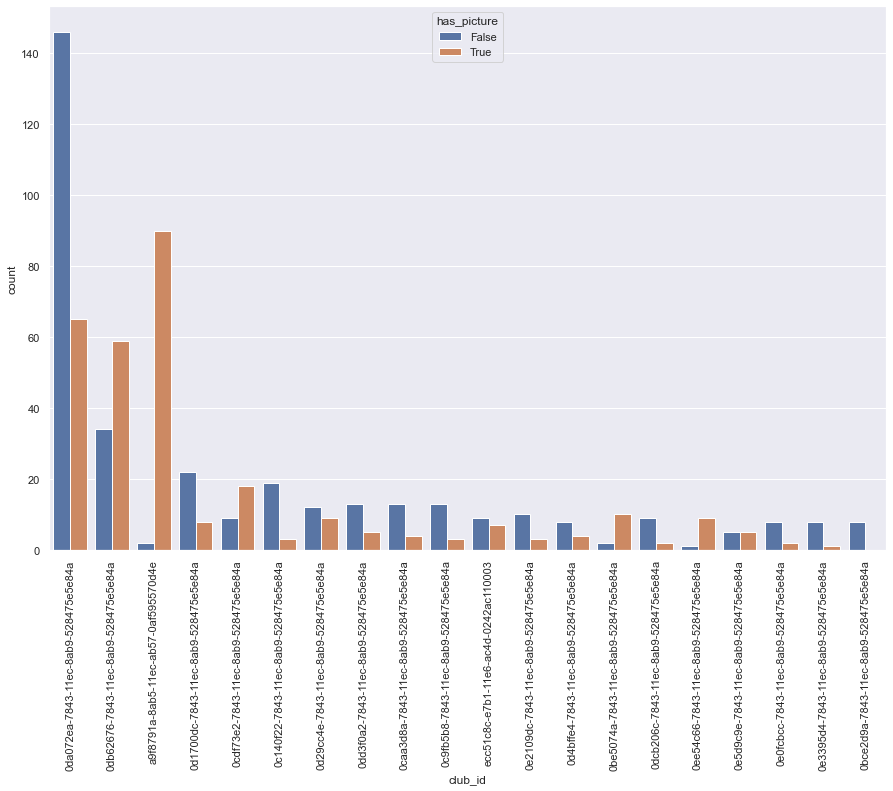

In [79]:
# relation between club 
plt.xticks(rotation=90)
top_club_ids = club_id_count_day_1_comments_and_posts.loc[club_id_count_day_1_comments_and_posts["message_type"] == "count_comments", "club_id"].iloc[:20]
comments_top_clubs = comments.loc[comments["posted_day_1"] & comments["club_id"].isin(top_club_ids)]
ax = sns.countplot(x="club_id", hue="has_picture", data=comments_top_clubs, order=top_club_ids)


# From insights to a (simple) recommendation algorithm

## What we know

- Posts and Comments which are part of a club generate more comments and likes, even if most contributions from day 1 are not put in club, we should recommend their content. Furthermore, clubs are an easy way to select specific topics

- Posts and comments having a picture generate far less comments but more likes, ... but most posts/comments published on day 1 contain a picture. The decision here is unclear. If we want moms to put a 'comment' then posts without pictures should be prioritized. If we want them to post, then having a picture should not be taken into account.

- A very large part of the first comments happen in 3 clubs: lets only recommend posts from these 3 clubs. 

- Depending on what we target (posts or comments), we should define a priority (number of posts in recent history ?) to choose a club.

## Let's put this in an algorithm:

The propose algorithm is pretty simple. It only relies on the insights found in this notebook and a bit of intuition.
Some of the numbers are arbitrary and should be discussed with product experts.

The algorithm implementation leverages 2 services:
- A scheduled one which compute, for posts, a probability of being recommended to the new users and store it in a dedicated base. Only the recent posts can be recommended (so the topics are alive + we only perform small and fast data requests).
- A live one, which returns a list of posts chosen on their probability to be recommended.


* Part 1: Compute_recommandation_probability:
    - For each post taken from a recent period in time and on the most active clubs: compute a probability of being recommended to the new users. Store it in a dedicated base. 
    - This part runs with a scheduler, every hour (or day)
    - Arguments:
        - historical_depth: the number of days from which the posts can be recommended
        - clubs_number: the number of clubs, chosen based on the number of publications from moms on the given historical_depth, from which the posts can be recommended
    - Output: None. (Update a dababase with post_id and recommandation_probability)
    - Steps:
        - Identify the current *clubs_number* mostly used clubs for moms posts/comments on day 1
        - Compute the club_priority of each club: <br>
        ```club_priority = (number of posts + number of comments in the club) / (total number of posts/comments) ```
        - Compute the probability to be recommended of each post: <br>
        ```((2 * comments_count) + (1 * like_count) - (post_ellapsed_time_from_creation in days * 10)) * club_priority```
        
        
Note: a simpler version could be implemented in the first place which take a list of {clubs_id: proirity} into account rather than computing them. 


* Part2: get_recommendations:
    - Draw n 'post_id' based on their probability to be recommended.
    - This is called live, when the user is connected to the app.

    - Arguments:
        - n_posts : number of post_id to return
    - output:
        - a list of post_id
       

In [ ]:
# TODO : mettre des titres
# fig.suptitle('Bigger 1 row x 2 columns axes with no data')

# To go further ...

Linking the original post_id for each comment would be a very valuable information, which would allow to improve greatly the suggested algorithm.

Historical view of which post has been consulted by which mom (and when) would also be a great help.

A list of the moms interest would definitly help as well.

Use recommendations systems algorithms: for this we will need more informations about posts and users. <br>
Some of them might be extracted using NLP technics.
We will also need what the user is currently viewing, to choose recommendations in link with this post.

# Appendices

## Attempt to identify what makes moms post on day 1 using machine learning

To understand why some moms posts/comments on day 1 and some don't, a common technic consist in trying to predict if a mom will post on day 1, given all we know about her. We can then dig into the obtained machine learning model to check how it built its decisions and extract some human understandable insights on the moms behaviours.

Unfortunatly, due to the lack of personal informations about moms and some data quality issues, this approach didn't provide the expected outputs. Still, it shows some insights about the moms themselves and put light on some easy to solve problems which would have a direct impact on future data science use cases feasability.

Methodology:
- Compute a probability that a mom posts on its first day, leveraging what we know about her, using machine learning algorithm random forest.
- Use the random forest "feature importance" field to identify the drivers that make them post.

In [30]:
# Keep only info which should be available on day 1
moms_subset = moms.loc[:, [ "children_count", 
                              "filled_birthdate",
                              "age",
                              "is_private", 
                              "is_trying", 
                              "is_mom", 
                              "is_pregnant", 
                              "comments_on_first_day", 
                              "posts_on_first_day", 
                              "posts_or_comments_on_first_day"]]

In [31]:
# target
y = moms_subset["posts_or_comments_on_first_day"]
# features
X = moms_subset.drop([ "is_mom",
                        "comments_on_first_day", 
                        "posts_on_first_day", 
                        "posts_or_comments_on_first_day"], axis=1)

# age NaNs are replaced by the mean because machine learning algorithms can't handle NaNs
age_impute = X["age"].mean()
X.loc[X["age"].isnull(), "age"] = age_impute

In [32]:
# Compute a classification task on the moms who posted on first day vs others in order to use the 'feature_importance'
# field provided by the RandomForestClassifier algorithm.

from sklearn.ensemble import RandomForestClassifier

feature_names = X.columns
forest = RandomForestClassifier(max_depth=5, n_estimators=50, random_state=0)
forest.fit(X, y)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=0)

In [33]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

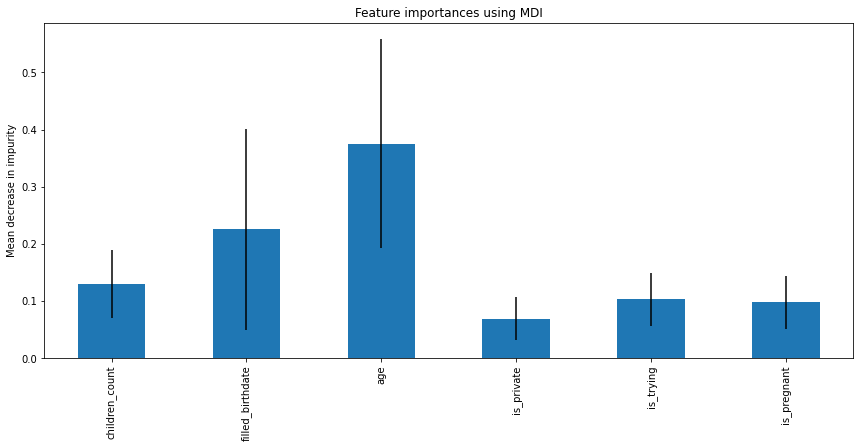

In [34]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax, fig=fig)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.set_size_inches(13, 8)

The 3 main factors that differenciate moms who comment or post the first day are 
- age
- filled_birthdate
- the number of children

Let's investigate a little bit more on those 3 dimensions.

### Filled birthdate

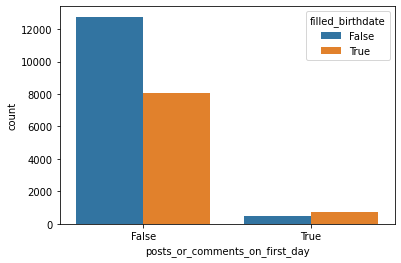

In [44]:
ax = sns.countplot(hue="filled_birthdate", x="posts_or_comments_on_first_day", data=moms_subset)

Among moms who posted 1st day, the majority had filled its birtdate, which is not the case for those who didn't post. It can be interpreted as the fact that these moms are more implicated (or less suspicious) about the app as a general state of mind.

### Children count

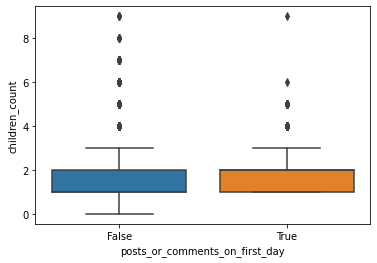

In [35]:
ax = sns.boxplot(x="posts_or_comments_on_first_day", y="children_count", data=moms_subset)

50% of moms have 1 or 2 children.
Many users are tagged as mom despite having 0 child, which indicates that the notion of mom is unclear (pregnant womens with no previous child are they considered as mom ?)

Surprisingly, no "mom" with 0 child has posted or commented on her first day on the app, which could be interpreted in several ways, depending on the reason why they appears as being a "mom" (further investigation needed).

In the end, the algorihm finds that moms with more children are more inclined to post/comment on the first day but it is most probably a side effect due to the fact that "0 children moms" did not post.

Note: moms with 0 child is a data quality issue which should be taken care off seriously because bad data totally nullify the power of machine learning and lead to bad data based decisions. Furthermore, it greatly lower the production capacity of data scientists/analysts since they have to spend most their time taking care of data quality issues at their level.

To mitigate this kind of issues I recommend:
- Build a data dictionnary: defines clearly the terms used in data. The definitions are shared between the organization so everyone talks about the same thing with the same words and newcomers have a clear reference when facing ambiguities. Responsibility to define the terms of dictionnary have to be clear (one people/team is responsible for the terms of a specific domain)

- Monitor data quality as close as possible from its creation. Just like unit tests with code, monitoring data quality to detect issues ASAP will greatly decrease the costs of a later remediation.

### Age

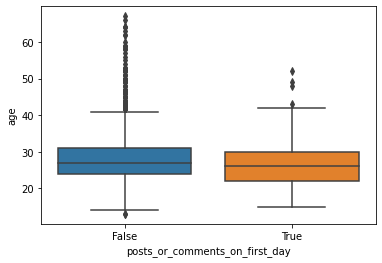

In [36]:
ax = sns.boxplot(x="posts_or_comments_on_first_day", y="age", data=moms_subset)

In [37]:
#suppr les ages imputés
print(moms_subset.loc[moms_subset["posts_or_comments_on_first_day"], "age"].mean())
print(moms_subset.loc[~moms_subset["posts_or_comments_on_first_day"], "age"].mean())

26.573859941454394
27.86043396859684


50% of the moms are between 25 and 30 years old. 

The difference in age distribution between moms who post on first day and moms who don't doesn't seem very significant, which might indicate that the relation between age and 'post or comment on first day' is not linear. Further investagion could show that a specific age group is more inclined to post or comment on first day, probably younger ones.

Note: While age should be a very useful information for many data science use cases (content recommendation, personnalized adds, ...) it doesn't seem to be a mandatory field to be able to connect to WeMoms. It is actually missing for more than 50% of the moms.